In [3]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from scipy.integrate import solve_ivp, quad
from scipy.optimize import fsolve
from scipy.spatial.distance import pdist, squareform

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

In [1]:
class LennardJonesGauss:
    def __init__(self, eps=1.0, r0=1.7):
        self.eps = eps
        self.r0 = r0
        self.sigma = 0.02**0.5*r0
    
    def potential(self, r):
        return r**-12 - 2*r**-6 + self.eps*np.exp(-(r-self.r0)**2/(2*self.sigma**2))

In [124]:
class LennardJonesGauss:
    def __init__(self, static_coords=None, dynamic_coords=None, eps=1.0, r0=1.7, kT=1, x_range=[1,9], y_range=[1,9]):
        if static_coords is None and dynamic_coords is None:
            raise ValueError("Please provide either static_coords or dynamic_coords as a list of coordinates, [[x1, y1], [x2, y2], ...]")
        
        self.static_coords = np.asarray(static_coords) if static_coords is not None else None
        self.dynamic_coords = np.asarray(dynamic_coords) if dynamic_coords is not None else None
        self.eps = eps
        self.r0 = r0
        self.kT = kT
        self.sigma = 0.02**0.5*r0

        if static_coords is None:
            self.all_coords = dynamic_coords
            self.dists = pdist(self.all_coords)
            self.rs = [dynamic_coords]
            self.Es = [self.energy()]
        elif dynamic_coords is None:
            self.all_coords = static_coords
            self.dists = pdist(self.all_coords)
        else:
            self.all_coords = np.concatenate([self.static_coords, self.dynamic_coords])
            self.dists = pdist(self.all_coords)
            self.rs = [dynamic_coords[0]]
            self.Es = [self.energy()]
        self.x_range = x_range
        self.y_range = y_range
        
    def potential(self, r):
        return r**-12 - 2*r**-6 - self.eps*np.exp(-(r-self.r0)**2/(2*self.sigma**2))
    
    def potential_gradient(self, r):
        return -12*r**-13 + 12*r**-7 + self.eps*(r-self.r0)/(self.sigma**2) * np.exp(-(r-self.r0)**2/(2*self.sigma**2))
    
    def force(self, r):
        return -self.potential_gradient(r)
    
    def force_unit_vector(self, r):
        return self.force(r)/np.linalg.norm(self.force(r), axis=1).reshape(-1, 1)

    def energy(self, dists=None):
        if dists is None:
            dists = self.dists
        return np.sum(self.potential(dists))
    
    def plot_atoms(self, ax):
        energy = self.energy(pdist(self.rs[-1]))
        ax.set(xlabel=r"$x$", ylabel=r"$y$", title=fr"$E = {energy:.3f}$", aspect="equal")
        ax.grid(alpha=0.5)
        if self.static_coords is not None:
            ax.scatter(*self.static_coords.T, s=100)
        if self.dynamic_coords is not None:
            ax.scatter(*self.dynamic_coords.T, s=100)
    
    def energy_at_point(self, point):
        point = np.array(point)
        all_coords_ = np.concatenate([self.all_coords, [point]])
        dists = pdist(all_coords_)
        return np.sum(self.potential(dists))
    
    def plot_energy_landscape(self, ax, x_range=None, y_range=None, levels=20, cmap='hot_r'):
        if x_range is None:
            x_range = self.x_range
        if y_range is None:
            y_range = self.y_range
        
        x = np.linspace(*x_range, 100)
        y = np.linspace(*y_range, 100)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)
        for i in range(len(x)):
            for j in range(len(y)):
                Z[j,i] = self.energy_at_point([x[i], y[j]])
        ax.set(xlabel=r"$x$", ylabel=r"$y$", title=r"Energy landscape", aspect="equal", xlim=x_range, ylim=y_range)
        ax.grid(alpha=0.5)
        ax.contourf(X, Y, Z, levels=levels, cmap=cmap)
    
    def step(self):
        if self.dynamic_coords is None:
            raise ValueError("Sampling cannot be done without dynamic coordinates. Please provide dynamic coordinates during initialization.")
        r_old = self.rs[-1]
        E_old = self.Es[-1]
        N_atoms = len(r_old)

        r_new = r_old + np.cos(2*np.pi*np.random.rand(N_atoms, 2))
        dists = pdist(r_new)
        E_new = self.energy(dists)
        DeltaE = E_new - E_old

        if np.random.rand() < np.exp(-DeltaE/self.kT):
            self.rs.append(r_new)
            self.Es.append(E_new)
        else:
            self.rs.append(r_old)
            self.Es.append(E_old)
    
    def search(self, N_steps=9):
        for _ in range(N_steps):
            self.step()
        self.dynamic_coords = self.rs[-1]
    
    def plot_trajectory(self, ax):
        ax.plot(*np.array(self.rs).T, "o-")

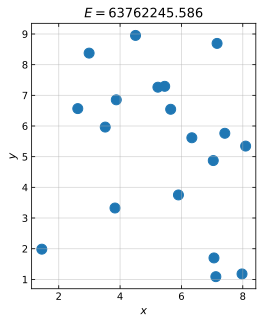

In [151]:
static_coords = None
N_atoms = 19
dynamic_xs = np.random.uniform(1, 9, N_atoms)
dynamic_ys = np.random.uniform(1, 9, N_atoms)
dynamic_coords = np.concatenate((dynamic_xs, dynamic_ys)).reshape(N_atoms, 2)

lgj = LennardJonesGauss(static_coords, dynamic_coords)
fig, ax = plt.subplots()
lgj.plot_atoms(ax)

C:\Users\Jakob\AppData\Local\Temp\ipykernel_39140\2816770335.py:80: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp(-DeltaE/self.kT):


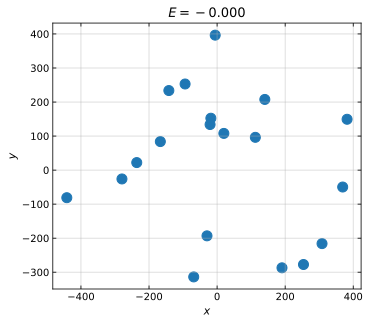

In [152]:
lgj.search(100000)
fig, ax = plt.subplots()
lgj.plot_atoms(ax)

In [161]:
lgj.dynamic_coords

array([[ 112.364,   96.321],
       [ 253.807, -277.339],
       [ 190.624, -287.035],
       [ -94.026,  252.979],
       [ 140.212,  207.639],
       [-141.732,  233.729],
       [-236.028,   22.135],
       [ 308.277, -215.948],
       [ 368.965,  -49.686],
       [  19.866,  107.859],
       [-441.516,  -81.064],
       [ -20.62 ,  133.908],
       [  -5.551,  396.496],
       [ -29.695, -193.116],
       [-279.537,  -25.99 ],
       [ -68.677, -313.769],
       [ 381.89 ,  149.365],
       [-166.761,   83.818],
       [ -18.306,  152.43 ]])

In [164]:
lgj.dynamic_coords/np.linalg.norm(lgj.dynamic_coords, axis=1).reshape(-1,1)

array([[ 0.759,  0.651],
       [ 0.675, -0.738],
       [ 0.553, -0.833],
       [-0.348,  0.937],
       [ 0.56 ,  0.829],
       [-0.519,  0.855],
       [-0.996,  0.093],
       [ 0.819, -0.574],
       [ 0.991, -0.133],
       [ 0.181,  0.983],
       [-0.984, -0.181],
       [-0.152,  0.988],
       [-0.014,  1.   ],
       [-0.152, -0.988],
       [-0.996, -0.093],
       [-0.214, -0.977],
       [ 0.931,  0.364],
       [-0.893,  0.449],
       [-0.119,  0.993]])

In [165]:
(-0.119)**2+(0.993)**2

1.00021